## Sentiment Analysis
### Using IMDB Dataset of 50K Movie Reviews

A Fellowship.AI Code Challenge Submission By [@arjunraghunandanan](https://www.kaggle.com/arjunraghunandanan)

www.arjunraghunandanan.com | September 2024 

---

This is a final submission **public notebook** after experimentations in several other private notebooks in kaggle / google colab / python scripts. Only the final solution code is presented here. 


### About the Data

**Dataset:**

IMDB Dataset of 50K Movie Reviews

**Description of Original Dataset**

This dataset is designed for binary sentiment classification (positive or negative) of movie reviews. It contains a significantly larger amount of data than previous benchmark datasets. The dataset is split into 25,000 reviews for training and 25,000 for testing.  Additionally, there is unlabeled data that can be utilized. The dataset is available in both raw text format and a processed bag-of-words format.

**Source:**
* Lakshmipathi N [lakshmi25npathi]. IMDB Dataset of 50K Movie Reviews. kaggle.com
* [kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)
* Original Dataset: ai.stanford.edu/~amaas/data/sentiment/
---

In [1]:
# Input data files are available in the read-only "../input/" directory
# Write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# Write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# @title Installing & Importing Necessary Packages

# Trying to repeat the steps using Tensorflow 2.15, 2.16, 2.17 versions shows errors downstream during classifier building with no easy workaround. So, staying with original 2.13 version used in sample code
!pip install -U --quiet "tensorflow-text==2.13.*"
!pip install --quiet "tf-models-official==2.13.*"

# uncomment this if you dont want the installing logs, Warnings will still show up. 
# from IPython.display import clear_output
# clear_output()


import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import os
import pickle
import re
import string

tf.get_logger().setLevel('ERROR')


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.8.3 requires cubinlinker, which is not installed.
cudf 24.8.3 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.8.3 requires ptxcompiler, which is not installed.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.8.3 requires cupy-cuda11x>=12.0.0, which is not installed.
ucxx 0.39.1 requires libucx>=1.15.0, which is not installed.
sqlalchemy 2.0.30 requires typing-extensions>=4.6.0, but you have typing-extensions 4.5.0 which is incompatible.
albumentations 1.4.15 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
altair 5.4.1 requires typing-extensions>=4.10.0; python_version < "3.13", but you have typing-extensions 4.5.0 which is incompatible.
apache-beam 2.46.0 requires cloudpickle~=2.2.1, but you have cloudpickle 3.0.0 which is incompatible

In [3]:
# Data Import from Notebook Dataset Input. 
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

# Uncomment and run the following if you are running outside of kaggle. 
# if not os.path.exists('IMDB Dataset.csv'):
#     import kaggle
#     !kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
#     !unzip imdb-dataset-of-50k-movie-reviews.zip
#df = pd.read_csv('IMDB Dataset.csv')

### Data Clean-Up
* **Sentiment Encoding** : Convert sentiment labels to numerical values for machine learning compatibility.
* **Text Cleaning**: Remove irrelevant characters and standardize reviews.
* **Index Reset**: Ensure a consistent index after data cleaning.

In [4]:
# Map 'positive' to 1 and 'negative' to 0
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})
# Define a function that cleans the text in a single step like removing html tags, converting to lowercase, removing punctuations, removing number's etc that are slightly less relevant and more efficient when embedding.
def clean_text(text):
    text = re.sub('<[^<]+?>', '', text)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    return text
df.loc[:, 'review'] = df['review'].apply(clean_text)
# Resetting Index to reflect Dropped Duplicates. else index would stay same from before causing KeyError when a dropped column is refered.
df = df.reset_index(drop=True)

### Data Splitting

In this section, the original dataset `df` is divided into three subsets:

- **Training Set (train_df):** This will be used to train the machine learning model.
- **Testing Set (test_df):** This will be used to evaluate the model's performance on unseen data.
- **Validation Set (val_df):** This will be used for hyperparameter tuning and model selection during the development process.

The splits are done using the `train_test_split` function from the `sklearn.model_selection` module. The `test_size` parameter controls the proportion of data allocated to each set. The `random_state` ensures reproducibility of the splits, and `shuffle=False` maintains the original order of the data.

In [5]:
train_df, test_df = train_test_split(df, test_size=0.4, random_state=100, shuffle=False)
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=100, shuffle=False)

print(f"Shapes of the split datasets: \n"
      f"Training Set: {train_df.shape}\n"
      f"Testing Set: {test_df.shape}\n"
      f"Validation Set: {val_df.shape}")


print("\nExample Row from Training Set:")
print(train_df.head(1))

print("\nExample Row from Testing Set:")
print(test_df.head(1))

print("\nExample Row from Validation Set:")
print(val_df.head(1))

# Ignore the index order as its not needed. 

Shapes of the split datasets: 
Training Set: (30000, 2)
Testing Set: (10000, 2)
Validation Set: (10000, 2)

Example Row from Training Set:
                                              review  sentiment
0  one of the other reviewers has mentioned that ...          1

Example Row from Testing Set:
                                                  review  sentiment
30000  one of quite a few cartoon scooby doo films sc...          1

Example Row from Validation Set:
                                                  review  sentiment
40000  first off i want to say that i lean liberal on...          0


### Dataset Conversion
**TensorFlow Datasets**: Convert Pandas DataFrames (train_df, val_df, test_df) into TensorFlow Datasets (train_ds, val_ds, test_ds) for efficient data handling during model training and evaluation. The data is then batched with a size of 32 and prefetching is applied using `tf.data.AUTOTUNE` to optimize data loading performance.

**Note** : I wanted to use GPU to train the model but, I still ended up training on Kaggle CPU Runtime because I couldn't figure out how to train it on GPU runtime even after playing around with it. I was able to work with GPU in Google Colab but the runtime abruptly disconnects sometimes during training due to inactivity hence I decided to move on use kaggle runtime. 

In [6]:
# Convert DataFrames to TensorFlow Datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_df['review'].values, train_df['sentiment'].values))
val_ds = tf.data.Dataset.from_tensor_slices((val_df['review'].values, val_df['sentiment'].values))
test_ds = tf.data.Dataset.from_tensor_slices((test_df['review'].values, test_df['sentiment'].values))

# Batching and prefetching
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
train_ds = train_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# Print shapes of the first batch in each dataset just to show batching
for reviews, labels in train_ds.take(1):
    print(f"Shape of reviews in a training batch: {reviews.shape}")
    print(f"Shape of labels in a training batch: {labels.shape}")

for reviews, labels in val_ds.take(1):
    print(f"Shape of reviews in a validation batch: {reviews.shape}")
    print(f"Shape of labels in a validation batch: {labels.shape}")

for reviews, labels in test_ds.take(1):
    print(f"Shape of reviews in a testing batch: {reviews.shape}")
    print(f"Shape of labels in a testing batch: {labels.shape}")

Shape of reviews in a training batch: (32,)
Shape of labels in a training batch: (32,)
Shape of reviews in a validation batch: (32,)
Shape of labels in a validation batch: (32,)
Shape of reviews in a testing batch: (32,)
Shape of labels in a testing batch: (32,)


### BERT model loading and preprocessing
This code sets up a BERT model for text processing. It uses a smaller BERT variant (`small_bert/bert_en_uncased_L-4_H-512_A-8`) from TensorFlow Hub. Two components are loaded: a preprocessing layer (`bert_preprocess_model`) to prepare input text, and the BERT encoder (`bert_model`) to extract meaningful features from the text. The encoder is set to be trainable, allowing fine-tuning during training.

In [7]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')

# Simple check: Print the model summaries
print("BERT Preprocess Model Summary:")
print(bert_preprocess_model.get_config())

print("\nBERT Model Summary:")
print(bert_model.get_config())

BERT Preprocess Model Summary:
{'name': 'keras_layer', 'trainable': False, 'dtype': 'float32', 'handle': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'}

BERT Model Summary:
{'name': 'BERT_encoder', 'trainable': True, 'dtype': 'float32', 'handle': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'}


### Model definition
- **Define Input Layer**: The model starts with a text input layer (`text_input`) that accepts strings as input.
- **Preprocessing**: A preprocessing layer (`preprocessing_layer`) is added using the BERT preprocessing model from TensorFlow Hub. It prepares the input text for the BERT encoder.
- **BERT Encoder**: The preprocessed text is passed into a trainable BERT encoder (`encoder`), which extracts features from the input.
- **Pooling Output**: The model uses the `pooled_output` from the encoder (representing the entire input text) as the feature vector.
- **Dropout**: A dropout layer (`Dropout(0.1)`) is applied to reduce overfitting by randomly deactivating 10% of the neurons.
- **Dense Layer**: Finally, a dense layer with one output neuron (`Dense(1)`) is added for binary classification (sentiment prediction).
- **Build Model**: The function returns the full classifier model, combining all layers.

The model is built and ready for use.

### Loss, Metrics, and Optimizer Setup

- **Loss Function**: 
  - `tf.keras.losses.BinaryCrossentropy(from_logits=True)` is used as the loss function. It computes the binary cross-entropy loss, which is ideal for binary classification tasks (e.g., positive vs. negative sentiment). The `from_logits=True` argument indicates that the output of the model is raw scores (logits) that need to be transformed into probabilities.

- **Metrics**: 
  - `tf.metrics.BinaryAccuracy()` is set as the evaluation metric. This metric calculates the accuracy of the model, measuring how often the predictions match the true labels.

These configurations are essential for training a binary classifier model, where the goal is to minimize the cross-entropy loss and maximize accu

In [8]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [9]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()

# # The code below will create a diagram of the classifier_model with the shapes of the inputs and outputs displayed. 
model_diagram_path = '/kaggle/working/classifier_model_diagram.png'
tf.keras.utils.plot_model(classifier_model, to_file=model_diagram_path, show_shapes=True, dpi=64)

print(f"Model diagram saved at: {model_diagram_path}")

Model diagram saved at: /kaggle/working/classifier_model_diagram.png


### Model Training Setup

- **Epochs**: The model will be trained for 5 epochs (`epochs = 5`).
- **Steps per Epoch**: The number of steps in each epoch is calculated based on the dataset size and batch size (`steps_per_epoch = train_df.shape[0] // batch_size`).
- **Training Steps**: The total number of training steps is determined by multiplying steps per epoch and epochs (`num_train_steps = steps_per_epoch * epochs`).
- **Warmup Steps**: 10% of the training steps are used for learning rate warmup (`num_warmup_steps = int(0.1 * num_train_steps)`).
- **Optimizer**: An AdamW optimizer is created with a learning rate of `3e-5`. It incorporates warmup steps (`optimizer_type='adamw'`).
- **Model Compilation**: The model is compiled with the AdamW optimizer, binary cross-entropy loss, and binary accuracy metrics.
- **Training**: The model is trained using the training dataset (`train_ds`), validated on the validation dataset (`val_ds`), and trained for 5 epochs.


In [10]:
epochs = 5  # change to 5, currently setting to 1 just to debug things in Full Auto Run Pipeline.
steps_per_epoch = train_df.shape[0] // batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

# Print values for Kaggle logs
print(f"Number of training steps: {num_train_steps}")
print(f"Number of warmup steps: {num_warmup_steps}")
print(f"Initial learning rate: {init_lr}")
print(f"Batch size: {batch_size}")

print(f"Setup Complete : Training the model for {epochs} epochs.")
history = classifier_model.fit(
  x=train_ds,
  validation_data=val_ds,
  epochs=epochs
)
print(f"Training Complete : Evaluating the model.")
loss, accuracy = classifier_model.evaluate(test_ds)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Number of training steps: 4685
Number of warmup steps: 468
Initial learning rate: 3e-05
Batch size: 32
Setup Complete : Training the model for 5 epochs.
Epoch 1/5
938/938 [==============================] - 3158s 3s/step - loss: 0.4537 - binary_accuracy: 0.7663 - val_loss: 0.3513 - val_binary_accuracy: 0.8507
Epoch 2/5
938/938 [==============================] - 3272s 3s/step - loss: 0.3041 - binary_accuracy: 0.8665 - val_loss: 0.3345 - val_binary_accuracy: 0.8555
Epoch 3/5
938/938 [==============================] - 3567s 4s/step - loss: 0.2297 - binary_accuracy: 0.9062 - val_loss: 0.3511 - val_binary_accuracy: 0.8705
Epoch 4/5
938/938 [==============================] - 3525s 4s/step - loss: 0.1755 - binary_accuracy: 0.9336 - val_loss: 0.3951 - val_binary_accuracy: 0.8684
Epoch 5/5
938/938 [==============================] - 3521s 4s/step - loss: 0.1372 - binary_accuracy: 0.9487 - val_loss: 0.4352 - val_binary_accuracy: 0.8717
Training Complete : Evaluating the model.
313/313 [===========

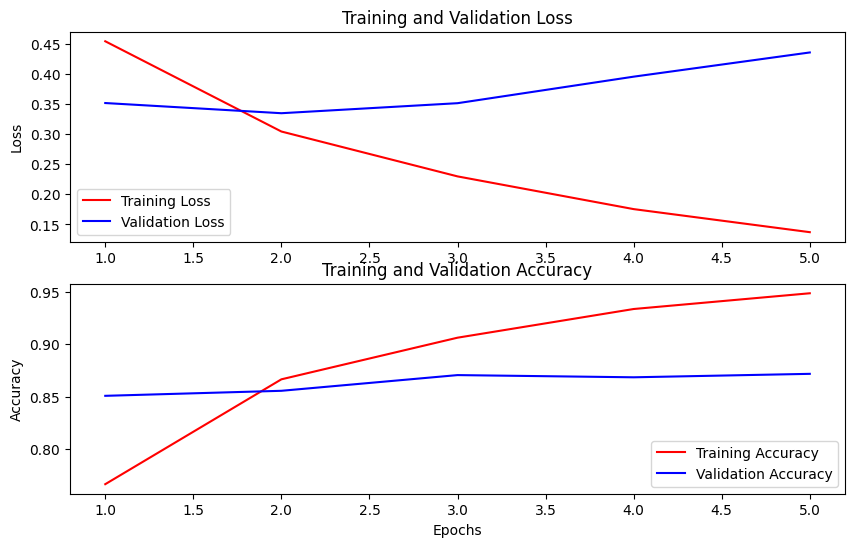

In [11]:
# Extract history metrics
history_dict = history.history
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plotting training and validation metrics
epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

# Plot Loss
plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

<Axes: title={'center': 'Training and Validation Accuracy'}>

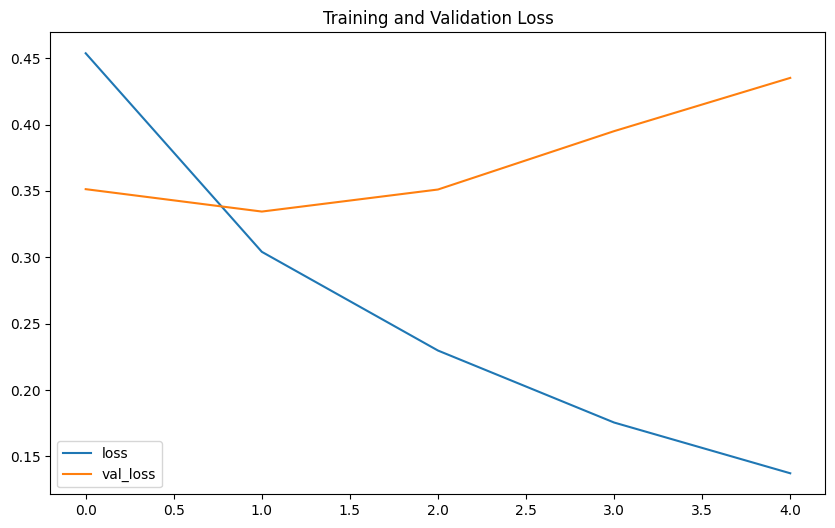

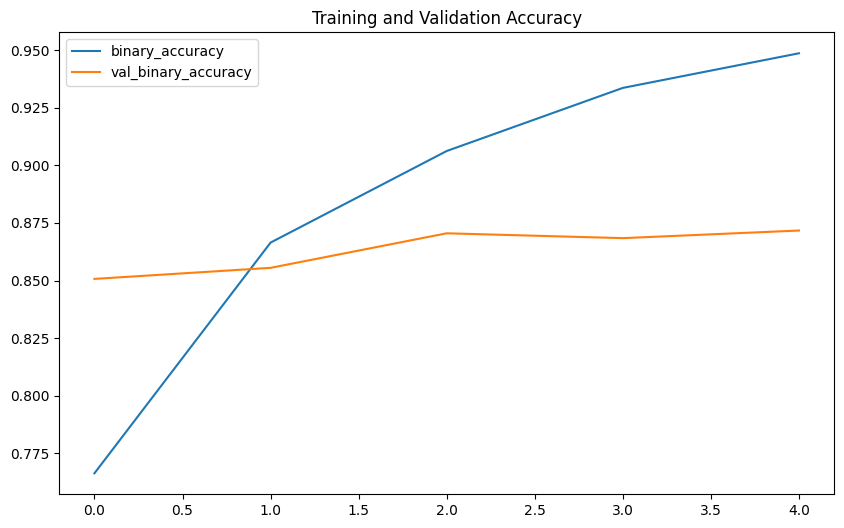

In [12]:
# Create dataframe from history metrics
df = pd.DataFrame(history.history)

# Plot
df[['loss', 'val_loss']].plot(title='Training and Validation Loss', figsize=(10, 6))
df[['binary_accuracy', 'val_binary_accuracy']].plot(title='Training and Validation Accuracy', figsize=(10, 6))

In [13]:
# Saving the model for Cloud Run
model_name = 'movie-review-classifier'
saved_model_path = f'/kaggle/working/{model_name}'
classifier_model.save(saved_model_path, include_optimizer=False)

# Saving the model as a pickle file
with open('classifier_model.pkl', 'wb') as f:
    pickle.dump(classifier_model, f)

print(f"SavedModel directory: {saved_model_path}")  # For Cloud Run
print("Pickle file: classifier_model.pkl")           # For general use
print("Model saved and reloaded successfully.")


SavedModel directory: /kaggle/working/movie-review-classifier
Pickle file: classifier_model.pkl
Model saved and reloaded successfully.


In [14]:
# Reloading the model to confirm it was saved correctly
reloaded_model = tf.saved_model.load(saved_model_path)
print(reloaded_model)

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7d4e510afeb0>


### Summary of Model Creation and Usage

- **Model Setup**: A binary text classification model using BERT was built to predict sentiment (positive or negative) from text. The configuration includes a binary cross-entropy loss function, accuracy metrics, and an AdamW optimizer for training.

- **Training**: The model was trained on a dataset of movie reviews for 5 epochs. BERT encodes the text, a dropout layer helps prevent overfitting, and the output provides a binary sentiment prediction.

- **How to Use the Model**:
  1. **Input**: Provide text reviews for prediction.
  2. **Preprocessing**: Input reviews are preprocessed using the BERT preprocessing layer.
  3. **Prediction**: Use `classifier_model.predict()` to get predictions on the preprocessed text. A positive score indicates positive sentiment, while a negative score indicates negative sentiment.

- **Example Usage**: Test the model by providing movie reviews. After preprocessing, the model predicts the sentiment and assigns a score to each review.

- **Saving the Model**: Save the trained model using the `pickle` library:
  ```python
  with open('classifier_model.pkl', 'wb') as f:
      pickle.dump(classifier_model, f)


In [15]:
test_reviews = [
    ["This movie was absolutely fantastic! The acting was superb, the story was gripping, and the visuals were stunning. I highly recommend it.", "Positive"],
    ["I was thoroughly disappointed with this film. The plot was predictable, the acting was subpar, and the pacing was slow. Save your money.", "Negative"],
    ["This movie was a complete waste of time. The story made no sense, the characters were unlikeable, and the ending was unsatisfying.", "Negative"],
    ["I absolutely loved this movie! It was funny, heartwarming, and thought-provoking. I can't wait to watch it again.", "Positive"]
]
# some example reviews with their expected prediction.
# This model only handles Positive vs Negative with a score. Not Neutral. You may use the score to determine Neutral Reviews

In [16]:

def predict_sentiment(reviews):
  predictions = classifier_model.predict(reviews)
  results = []
  for review, prediction in zip(reviews, predictions):
      score = prediction[0]
      sentiment = "Positive" if score > 0 else "Negative"
      results.append((review, sentiment, score))
  return results

review_texts = [review[0] for review in test_reviews]
expected_predictions = [review[1] for review in test_reviews]
predictions = predict_sentiment(review_texts)

print("{:<50} | {:<15} | {:<15} | {:<10}".format("Review (First 50 chars)", "Expected Prediction", "Prediction Made", "Score"))
print("-" * 90)

for review, expected_prediction, (predicted_review, predicted_sentiment, score) in zip(review_texts, expected_predictions, predictions):
  print("{:<50} | {:<15} | {:<15} | {:<10.4f}".format(review[:50], expected_prediction, predicted_sentiment, score))


1/1 [==============================] - 1s 628ms/step
Review (First 50 chars)                            | Expected Prediction | Prediction Made | Score     
------------------------------------------------------------------------------------------
This movie was absolutely fantastic! The acting wa | Positive        | Positive        | 6.3538    
I was thoroughly disappointed with this film. The  | Negative        | Negative        | -6.6555   
This movie was a complete waste of time. The story | Negative        | Negative        | -7.0820   
I absolutely loved this movie! It was funny, heart | Positive        | Positive        | 6.7379    


### Credits 
**Dataset** : Lakshmipathi N [lakshmi25npathi]. IMDB Dataset of 50K Movie Reviews.
kaggle.com Accessed September 25, 2024

**Sample Codes** : Copyright 2020 The TensorFlow Hub Authors. TensorFlow. (2024). text (Version master) 
[GitHub repository]. https://github.com/tensorflow/text/tree/master/docs/tutorials. Accessed September 26, 2024

**Challenge Program** : fellowship.ai. September 2024

Notebook by @arjunraghunandanan 2024